# Implicit regularization in Transfer Learning

Transfer Learning has been a hot topic in the field of machine learning for the past few years.

**The problem**: We aim to approximate a function $f : \mathbb{R}^d \rightarrow \mathbb{R}$ using a model $h : \mathbb{R}^d \rightarrow \mathbb{R}$, where $h$ is a neural network with parameters $\theta$. The challenge arises from the fact that the data generating distribution $\mathcal{D}$ is difficult to sample from, resulting in a small dataset $D = \{(x_i, y_i)\}_{i=1}^n$ with limited samples.

**The idea behind Transfer Learning**:
The core intuition lies in leveraging knowledge gained in one context (source domain or task) to improve learning in a different, but related context (target domain or task).


In [1]:
# Math Libraries
import numpy as np

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.models import resnet50, ResNet50_Weights

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tabulate import tabulate
from tqdm.notebook import tqdm
from plotly.offline import init_notebook_mode
from utils import visualize_loss_landscape_3d_plotly_browser

# Data Processing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Custom Modules
from utils import train_and_evaluate

SEED = 26
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

init_notebook_mode(connected=True)

Using device:  cuda


## Fine tuning

Number of training samples:  60000


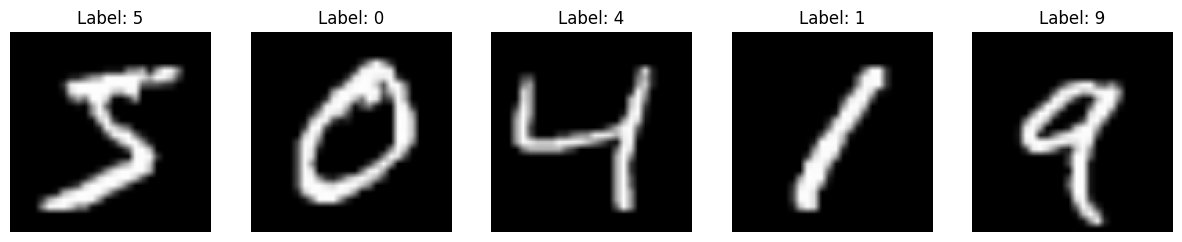

In [2]:
# Load the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # RGB
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])
train_dataset = MNIST(
    root = 'data',
    transform=transform,
    download=True,
    train=True
)
test_dataset = MNIST(
    root = 'data',
    transform=transform,
    download=True,
    train=False
)
num_classes = len(train_dataset.classes)
print("Number of training samples: ", len(train_dataset))

# Show some images
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0).numpy()
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
plt.show()

In [3]:
# Downsample the training dataset
train_dataset = torch.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), 50))

print("Number of training samples: ", len(train_dataset))

Number of training samples:  50


In [4]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
model_new        = resnet50(weights=None)
model_pretrained = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Adapt the last layer to the number of classes
model_new.fc = nn.Sequential(
    nn.Linear(model_new.fc.in_features, num_classes),
    nn.Softmax(dim=1)
)
model_pretrained.fc = nn.Sequential(
    nn.Linear(model_pretrained.fc.in_features, num_classes),
    nn.Softmax(dim=1)
)

## Fine tuning

In [6]:
n_epochs = 30
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer_new = optim.Adam(model_pretrained.parameters(), lr=lr)
optimizer_pretrained = optim.Adam(model_pretrained.parameters(), lr=lr)

model_new.to(device)
model_pretrained.to(device)

print(f"Number of parameters in the model: {sum(p.numel() for p in model_pretrained.parameters()):E}")

Number of parameters in the model: 2.352852E+07


In [7]:
losses_new, bacc_new, other_new = train_and_evaluate(
    model_new, train_loader, test_loader, criterion, optimizer_new, n_epochs, device
)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
losses_pretrained, bacc_pretrained, other_pretrained = train_and_evaluate(
    model_pretrained, train_loader, test_loader, criterion, optimizer_pretrained, n_epochs, device
)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
# Fresh new model
train_losses_new, test_losses_new = losses_new
train_bacc_new, test_bacc_new = bacc_new
weights_trajectory_new, grad_norms_new = other_new

# Pretrained model
train_losses_pretrained, test_losses_pretrained = losses_pretrained
train_bacc_pretrained, test_bacc_pretrained = bacc_pretrained
weights_trajectory_pretrained, grad_norms_pretrained = other_pretrained

In [17]:
# Best loss and balanced accuracy
table = [
    ["New model", np.min(test_losses_new), np.max(test_bacc_new)],
    ["Pretrained model", np.min(test_losses_pretrained), np.max(test_bacc_pretrained)]
]
print(tabulate(table, headers=["Model", "Best loss", "Best balanced accuracy"], tablefmt="fancy_grid", floatfmt=".4f"))

╒══════════════════╤═════════════╤══════════════════════════╕
│ Model            │   Best loss │   Best balanced accuracy │
╞══════════════════╪═════════════╪══════════════════════════╡
│ New model        │      2.3025 │                   0.1105 │
├──────────────────┼─────────────┼──────────────────────────┤
│ Pretrained model │      1.8018 │                   0.6554 │
╘══════════════════╧═════════════╧══════════════════════════╛


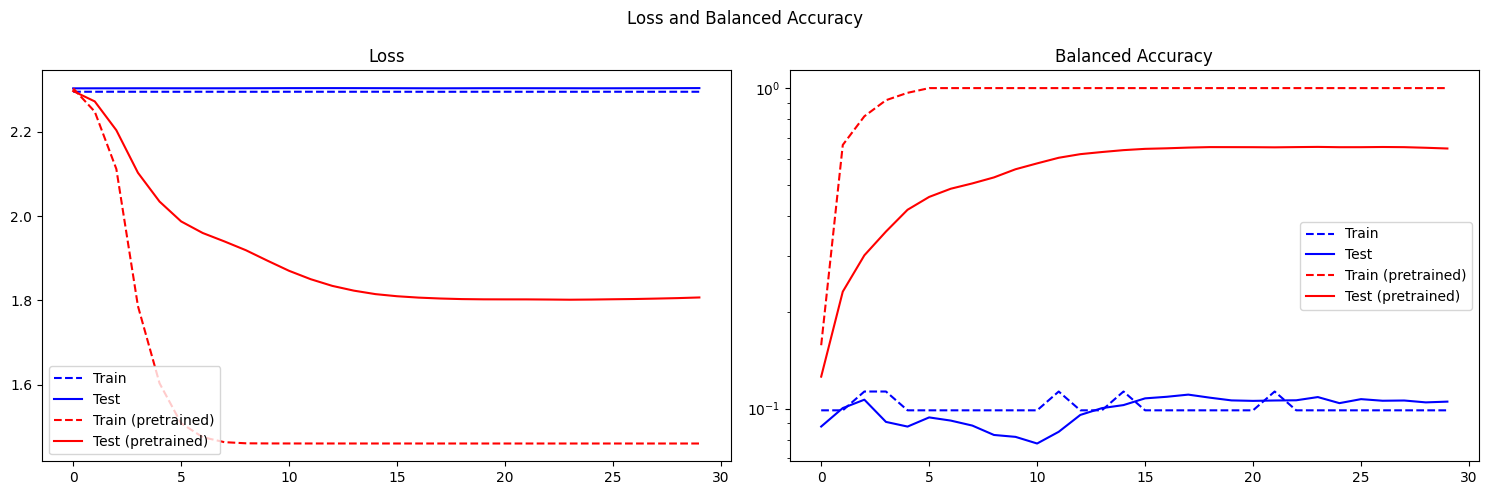

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  

fig.suptitle("Loss and Balanced Accuracy")

ax[0].plot(train_losses_new, label="Train", color="blue", linestyle="--")
ax[0].plot(test_losses_new, label="Test", color="blue")
ax[0].plot(train_losses_pretrained, label="Train (pretrained)", color="red", linestyle="--")
ax[0].plot(test_losses_pretrained, label="Test (pretrained)", color="red")
ax[0].set_title("Loss")
ax[0].legend()
# ax[0].set_yscale("log")

ax[1].plot(train_bacc_new, label="Train", color="blue", linestyle="--")
ax[1].plot(test_bacc_new, label="Test", color="blue")
ax[1].plot(train_bacc_pretrained, label="Train (pretrained)", color="red", linestyle="--")
ax[1].plot(test_bacc_pretrained, label="Test (pretrained)", color="red")
ax[1].set_title("Balanced Accuracy")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

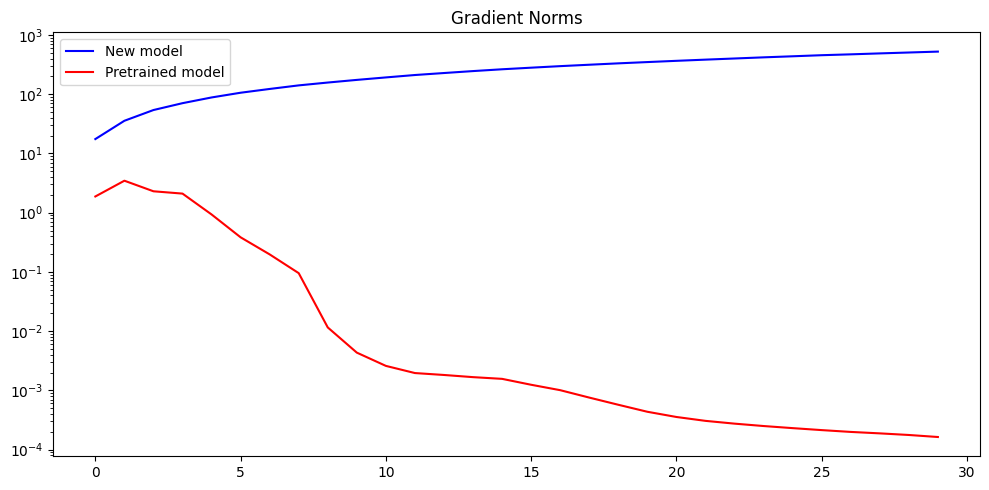

In [19]:
# Plot gradient norms
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(grad_norms_new, label="New model", color="blue")
ax.plot(grad_norms_pretrained, label="Pretrained model", color="red")
ax.set_title("Gradient Norms")
ax.legend()
ax.set_yscale("log")

plt.tight_layout()
plt.show()

In [20]:
len(weights_trajectory_new)

30

In [21]:
magnitude_change_overall_pretrained = []
alignment_change_overall_pretrained = []
angles_overall_pretrained = []
for i in range(1, len(weights_trajectory_pretrained)):
    flat_weights_prev = np.concatenate([p.flatten() for p in weights_trajectory_pretrained[i-1]])
    flat_weights = np.concatenate([p.flatten() for p in weights_trajectory_pretrained[i]])
    
    # Magnitude change
    magnitude_change = np.linalg.norm(flat_weights - flat_weights_prev) / np.linalg.norm(flat_weights_prev)
    magnitude_change_overall_pretrained.append(magnitude_change.item())

    # Alignment change
    alignment_change = np.dot(flat_weights_prev, flat_weights) / (np.linalg.norm(flat_weights_prev) * np.linalg.norm(flat_weights))
    alignment_change_overall_pretrained.append(alignment_change.item())   
    
    # Angle
    alignment = np.arccos(alignment_change) * 180 / np.pi if alignment_change < 1 else 0
    angles_overall_pretrained.append(alignment)

In [34]:
from matplotlib.backends.backend_pdf import PdfPages

# Create a PDF file
with PdfPages('plots.pdf') as pdf:
    # Plot Magnitude Change
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(magnitude_change_overall_pretrained, label="Pretrained model", color="red")
    # ax.set_title("Magnitude Change")
    ax.set_yscale("log")
    ax.set_ylabel("Relative Change")
    ax.set_xlabel("Epoch")
    plt.tight_layout()
    pdf.savefig(fig)  # Save the figure to the PDF
    plt.close(fig)  # Close the figure

    # Plot Angle Change
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(angles_overall_pretrained, label="Pretrained model", color="red")
    # ax.set_title("Angle Change")
    ax.set_ylabel("Angle (degrees)")
    ax.set_xlabel("Epoch")
    plt.tight_layout()
    pdf.savefig(fig)  # Save the figure to the PDF
    plt.close(fig)  # Close the figure

In [54]:
magnitude_change_layerwise_pretrained = []
alignment_change_layerwise_pretrained = []
angles_layerwise_pretrained = []

for i in range(1, len(weights_trajectory_pretrained)):
    magnitude_change_layerwise = []
    alignment_change_layerwise = []
    angles_layerwise = []
    for j in range(len(weights_trajectory_pretrained[i])):
        flat_weights_prev = weights_trajectory_pretrained[i-1][j].flatten()
        flat_weights = weights_trajectory_pretrained[i][j].flatten()

        # Magnitude change
        magnitude_change = np.linalg.norm(flat_weights - flat_weights_prev) / np.linalg.norm(flat_weights_prev)
        magnitude_change_layerwise.append(magnitude_change.item())
        
        # Alignment change
        alignment_change = np.dot(flat_weights_prev, flat_weights) / (np.linalg.norm(flat_weights_prev) * np.linalg.norm(flat_weights))
        alignment_change_layerwise.append(alignment_change.item())
        
        # Angle
        alignment = np.arccos(alignment_change) * 180 / np.pi if alignment_change < 1 else 0
        angles_layerwise.append(alignment)
        
    magnitude_change_layerwise_pretrained.append(magnitude_change_layerwise)
    alignment_change_layerwise_pretrained.append(alignment_change_layerwise)
    angles_layerwise_pretrained.append(angles_layerwise)

In [55]:
magnitude_change_layerwise_pretrained = np.array(magnitude_change_layerwise_pretrained)
alignment_change_layerwise_pretrained = np.array(alignment_change_layerwise_pretrained)
angles_layerwise_pretrained = np.array(angles_layerwise_pretrained)

# Save to disk each array
np.save("magnitude_change_layerwise_pretrained.npy", magnitude_change_layerwise_pretrained)
np.save("alignment_change_layerwise_pretrained.npy", alignment_change_layerwise_pretrained)
np.save("angles_layerwise_pretrained.npy", angles_layerwise_pretrained)

In [ ]:
model_pretrained_layers_names = [name for name, _ in model_pretrained.named_parameters()]

In [61]:
with open("model_pretrained_layers_names.txt", "w") as f:
    for name in model_pretrained_layers_names:
        f.write(name + "\n")

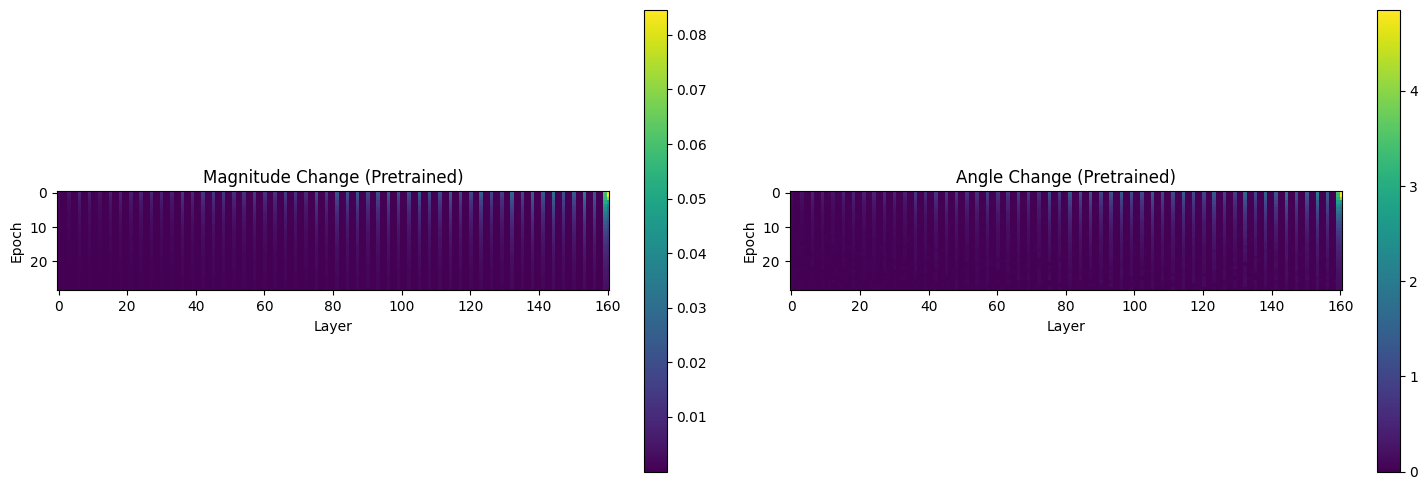

In [53]:
plt.figure(figsize=(15, 5))
# Heatmap of magnitude change
plt.subplot(1, 2, 1)
plt.imshow(magnitude_change_layerwise_pretrained, cmap="viridis")
# plt.imshow(m1)
plt.colorbar()
plt.title("Magnitude Change (Pretrained)")
plt.xlabel("Layer")
plt.ylabel("Epoch")

# Heatmap of alignment change
plt.subplot(1, 2, 2)
plt.imshow(angles_layerwise_pretrained, cmap="viridis")
plt.colorbar()
plt.title("Angle Change (Pretrained)")
plt.xlabel("Layer")
plt.ylabel("Epoch")

plt.tight_layout()
plt.show()

In [12]:
# Extract X_train and y_train tensors
X_train = []
y_train = []
for X, y in train_loader:
    X_train.append(X)
    y_train.append(y)
X_train = torch.cat(X_train, dim=0).to(device)
y_train = torch.cat(y_train, dim=0).to(device)

### Loss Landscape

In [13]:
visualize_loss_landscape_3d_plotly_browser(
    model = model_new,
    weights_trajectory=weights_trajectory_new[-10:],
    X_tensor = X_train,
    y_tensor = y_train,
    grid_size = 9,
    radius = 1,
    name = "new_model"
) 

: 

In [15]:
visualize_loss_landscape_3d_plotly_browser(
    model = model_pretrained,
    weights_trajectory=weights_trajectory_pretrained[-20:],
    X_tensor = X_train,
    y_tensor = y_train,
    grid_size = 15,
    radius = 1,
    name = "pretrained_model"
) 

  0%|          | 0/19 [00:00<?, ?it/s]

In [22]:
from joblib import Parallel, delayed
from plotly.offline import plot
from copy import deepcopy

def visualize_loss_landscape_3d_plotly_browser(model, weights_trajectory, X_tensor, y_tensor, grid_size=50, radius=5, name="model", traj_points=0):
    """
    Visualize the loss landscape in 3D by sampling over a grid in parameter space,
    with a user-defined radius around the current point.
    """
    # Copy the model to ensure the original model is not modified
    model = deepcopy(model)

    # Ensure the data points are on the device
    criterion = nn.CrossEntropyLoss()

    # Ensure the model is in evaluation mode
    model.eval()

    # Collect parameters
    params = np.concatenate([p.detach().cpu().numpy().flatten() for p in model.parameters()])
    num_params = len(params)

    # Generate two random orthogonal directions
    direction1 = np.random.randn(num_params)
    direction2 = np.random.randn(num_params)

    # Choose the direction as the main axes of variation in the weights
    pca = PCA(n_components=2)
    pca.fit(np.array([ np.concatenate([ w.reshape(-1) for w in weights ]) for weights in weights_trajectory ]))
    direction1, direction2 = pca.components_

    # Generate grid within the given radius
    alphas = np.linspace(-radius, radius, grid_size)
    betas = np.linspace(-radius, radius, grid_size)
    alpha_grid, beta_grid = np.meshgrid(alphas, betas)

    # Compute the loss value of the current model
    current_loss = criterion(model(X_tensor), y_tensor).item()

    # Compute loss values
    def compute_loss(i, j):
        perturbed_params = params + alpha_grid[i, j] * direction1 + beta_grid[i, j] * direction2
        start = 0
        with torch.no_grad():
            for param in model.parameters():
                numel = param.numel()
                param.copy_(
                    torch.tensor(perturbed_params[start:start + numel]).reshape(param.shape)
                )
                start += numel
            predictions = model(X_tensor)
            loss = criterion(predictions, y_tensor).item()
        return i, j, loss
    # losses = np.zeros_like(alpha_grid)
    # for i in tqdm(range(grid_size), leave=False):
    #     for j in range(grid_size):
    #         perturbed_params = params + alpha_grid[i, j] * direction1 + beta_grid[i, j] * direction2
    #         start = 0
    #         with torch.no_grad():
    #             for param in model.parameters():
    #                 numel = param.numel()
    #                 param.copy_(
    #                     torch.tensor(perturbed_params[start:start + numel]).reshape(param.shape)
    #                 )
    #                 start += numel
    #             predictions = model(X_tensor)
    #             loss = criterion(predictions, y_tensor).item()
    #             losses[i, j] = loss
    # Parallel computation of losses
    results = Parallel(n_jobs=-1)(delayed(compute_loss)(i, j) for i in range(grid_size) for j in range(grid_size))

    # Assemble results into a 2D losses array
    losses = np.zeros((grid_size, grid_size))
    for i, j, loss in results:
        losses[i, j] = loss

    # Project weight trajectory onto the two directions
    trajectory_points = []
    for weights in weights_trajectory:
        flat_weights = np.concatenate([w.flatten() for w in weights])
        alpha = np.dot(flat_weights - params, direction1)
        beta = np.dot(flat_weights - params, direction2)
        trajectory_points.append((alpha, beta))

    trajectory_points = np.array(trajectory_points)
    trajectory_alphas = trajectory_points[:, 0]
    trajectory_betas = trajectory_points[:, 1]
    trajectory_losses = []
    # Compute the loss values for the trajectory points
    for weights in weights_trajectory:
        start = 0
        with torch.no_grad():
            for param, w in zip(model.parameters(), weights):
                numel = param.numel()
                param.copy_(torch.tensor(w).reshape(param.shape))
                start += numel
            predictions = model(X_tensor)
            trajectory_losses.append(criterion(predictions, y_tensor).item())


    # Plot the 3D loss landscape using Plotly
    # Create the figure
    fig = go.Figure()

    # Add the surface plot
    fig.add_trace(go.Surface(z=losses, x=alpha_grid, y=beta_grid, colorscale='Viridis'))

    # Add the current point
    fig.add_trace(go.Scatter3d(
        x=[0],  # Replace with the actual x-coordinate of the current point
        y=[0],  # Replace with the actual y-coordinate of the current point
        z=[current_loss],
        mode='markers+text',
        marker=dict(size=8, color='red', symbol='diamond'),
        text=['Current Point'],
        textposition='top center',
        name='Current Point'
    ))

    # Add the trajectory - plot last `traj_points` points
    if traj_points > 0:
        fig.add_trace(go.Scatter3d(
            x=trajectory_alphas[-traj_points:],
            y=trajectory_betas[-traj_points:],
            z=trajectory_losses[-traj_points:],
            mode='lines+markers',
            marker=dict(size=5, color='blue'),
            line=dict(color='blue', width=2),
            name='Weight Trajectory'
        ))

    # Update layout
    fig.update_layout(
        title='3D Loss Landscape',
        scene=dict(
            xaxis_title='Direction 1',
            yaxis_title='Direction 2',
            zaxis_title='Loss',
            xaxis=dict(showspikes=False),
            yaxis=dict(showspikes=False),
            zaxis=dict(showspikes=False)
        ),
        margin=dict(l=0, r=0, b=0, t=50)
    )

    # Render in the browser
    filename = f'3d_loss_landscape_{name}.html'
    plot(fig, filename=filename, auto_open=True)
